# Installation


PyFWI can be installed using ```pip``` as

```console

    (.venv) $ pip install PyFWI

```
on OS or

```console

    (.venv) $ py -m pip install PyFWI

```

on Windows.

# Example

In this simple example, we use PyFWI to do forward modeling. So, we need to first import the following packages

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.append('../../src/')

import PyFWI.wave_propagation as wave
import PyFWI.acquisition as acq
import PyFWI.seiplot as splt
import PyFWI.model_dataset as md





A simple model can be created by using ```model_dataset``` module as

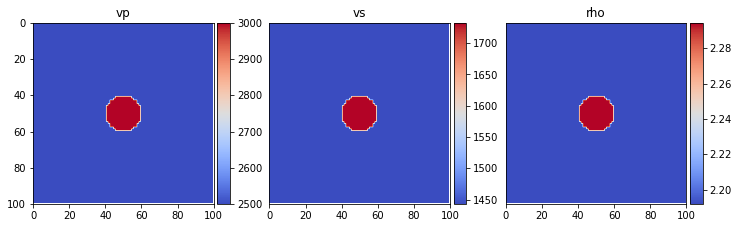

In [ ]:
Model = md.ModelGenerator('louboutin')
model = Model()


im = splt.earth_model(model, cmap='coolwarm')

Then we need to create an input dictionary as follow

In [ ]:
model_shape = model[[*model][0]].shape

inpa = {
    'ns': 1,  # Number of sources
    'seisout': 0,  # Type of output
    'sdo': 8,  # Order of FD
    'fdom': 15,  # Central frequency of source
    'dh': np.float32(7),  # Spatial sampling rate
    'dt': 0.0006,  # Temporal sampling rate
    'acq_type': 1,  # Type of acquisition (0: crosswell, 1: surface, 2: both)
    't': 0.8,  # Length of operation
    'npml': 20,  # Number of PML 
    'pmlR': 1e-5,  # Coefficient for PML (No need to change)
    'pml_dir': 2,  # type of boundary layer
    'device': 1, 
}

inpa['rec_dis'] =  1 * inpa['dh']  # Define the receivers' distance


Now, we obtain the location of sources and receivers based on specified parameters.

In [ ]:
offsetx = inpa['dh'] * model_shape[1]
depth = inpa['dh'] * model_shape[0]

src_loc, rec_loc, n_surface_rec, n_well_rec = acq.acq_parameters(inpa['ns'], inpa['rec_dis'], offsetx, depth, inpa['dh'], inpa['sdo'],
                                                              inpa['acq_type'])        
src_loc[:, 1] -= 5 * inpa['dh']

# Create the source
src = acq.Source(src_loc, inpa['dh'], inpa['dt'])
src.Ricker(inpa['fdom'])


Finally, we can have the forward modelling as 

In [ ]:
# Create the wave object
W = wave.WavePropagator(inpa, src, rec_loc, model_shape, n_well_rec, 20, inpa['seisout'])

# Call the forward modelling 
db_obs = W.forward_modeling(model, False)

We saved the wavefield at 20% of the time steps to be used for gradient calculation. The value of wavefield is accessible using the attribute ```W``` which is a dictionary for $V_x$, $V_z$, $\tau_x$, $\tau_z$, and $\tau_{xz}$ as ```vx```, ```vz```, ```taux```, ```tauz```, and ```tauxz```.
Each parameter is a 4D tensor. For example, we can have access to the last time step of $\tau_x$ for the first shot as ```W.W['taux'][:, :, 0, -1]```.

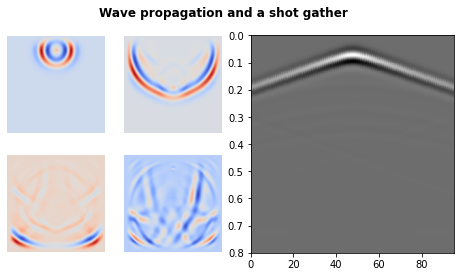

In [ ]:
fig = plt.figure(figsize=(8, 4))

count = 1

ax = fig.add_subplot(122)
ax = splt.seismic_section(ax, db_obs['taux'], t_axis=np.linspace(0, inpa['t'], W.nt))

ax_loc = [1, 2, 5, 6]
snapshots = [40, 80, 130, 180]

for i in range(len(snapshots)):
    ax = fig.add_subplot(2, 4, ax_loc[i])
    ax.imshow(W.W['taux'][:, :, 0, snapshots[i]], cmap='coolwarm')
    
    ax.axis('off')
    count += 1
fig.suptitle("Wave propagation and a shot gather", fontweight='bold');
